## 0. Import Library

In [1]:
import torch.utils.data as utils
import torch.nn.functional as F
import torch
import torch.nn as nn 
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import numpy as np
import pandas as pd
import math
import time

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
print(torch.__version__)

2.1.2+cu121


## Load Example Dataset

In [86]:
import pandas as pd

# Specify the file path
file_path = 'TruckParkingQuery_20220101_20220601.csv'

# Read data from the text file into a pandas DataFrame
df = pd.read_csv(file_path)  

df = df.iloc[:3000]

# Print or use the resulting DataFrame
df



,siteId,timestamp,capacity,lowThreshold,open,reportedAvailable,timeStampStatic,trend,trustdata
0,WI00039IS0011300SRSTARE11,2022-01-01T00:02:09Z,68,13,1,54,2020-07-31T18:57:57Z,FILLING,1
1,WI00039IS0011300SRSTARE11,2022-01-01T00:04:09Z,68,13,1,53,2020-07-31T18:57:57Z,FILLING,1
2,WI00039IS0011300SRSTARE11,2022-01-01T00:09:19Z,68,13,1,54,2020-07-31T18:57:57Z,FILLING,1
3,WI00039IS0011300SRSTARE11,2022-01-01T00:15:59Z,68,13,1,54,2020-07-31T18:57:57Z,STEADY,1
4,WI00039IS0011300SRSTARE11,2022-01-01T00:20:20Z,68,13,1,54,2020-07-31T18:57:57Z,STEADY,1
...,...,...,...,...,...,...,...,...,...
2995,WI00039IS0011300SRSTARE11,2022-01-06T16:26:20Z,68,13,1,61,2020-07-31T18:57:57Z,CLEARING,1
2996,WI00039IS0011300SRSTARE11,2022-01-06T16:28:17Z,68,13,1,60,2020-07-31T18:57:57Z,CLEARING,1
2997,WI00039IS0011300SRSTARE11,2022-01-06T16:28:49Z,68,13,1,59,2020-07-31T18:57:57Z,STEADY,1
2998,WI00039IS0011300SRSTARE11,2022-01-06T16:30:38Z,68,13,1,58,2020-07-31T18:57:57Z,STEADY,1


In [87]:
df.loc[df.reportedAvailable == 'LOW', 'reportedAvailable'] = 0
df['reportedAvailable'] = df['reportedAvailable'].astype(str).astype(int)

In [88]:
df['DateTime'] = pd.to_datetime(df['timestamp'])

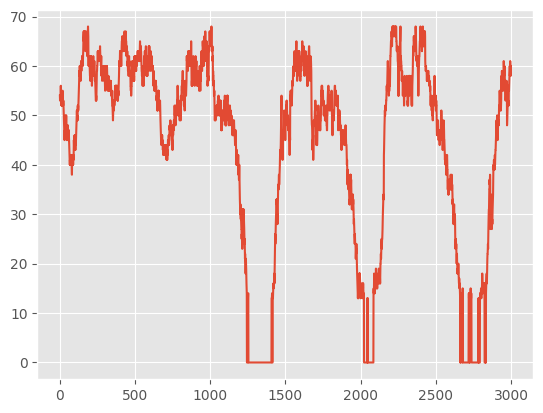

In [89]:
ax = df['reportedAvailable'].plot() 

In [90]:
df

,siteId,timestamp,capacity,lowThreshold,open,reportedAvailable,timeStampStatic,trend,trustdata,DateTime
0,WI00039IS0011300SRSTARE11,2022-01-01T00:02:09Z,68,13,1,54,2020-07-31T18:57:57Z,FILLING,1,2022-01-01 00:02:09+00:00
1,WI00039IS0011300SRSTARE11,2022-01-01T00:04:09Z,68,13,1,53,2020-07-31T18:57:57Z,FILLING,1,2022-01-01 00:04:09+00:00
2,WI00039IS0011300SRSTARE11,2022-01-01T00:09:19Z,68,13,1,54,2020-07-31T18:57:57Z,FILLING,1,2022-01-01 00:09:19+00:00
3,WI00039IS0011300SRSTARE11,2022-01-01T00:15:59Z,68,13,1,54,2020-07-31T18:57:57Z,STEADY,1,2022-01-01 00:15:59+00:00
4,WI00039IS0011300SRSTARE11,2022-01-01T00:20:20Z,68,13,1,54,2020-07-31T18:57:57Z,STEADY,1,2022-01-01 00:20:20+00:00
...,...,...,...,...,...,...,...,...,...,...
2995,WI00039IS0011300SRSTARE11,2022-01-06T16:26:20Z,68,13,1,61,2020-07-31T18:57:57Z,CLEARING,1,2022-01-06 16:26:20+00:00
2996,WI00039IS0011300SRSTARE11,2022-01-06T16:28:17Z,68,13,1,60,2020-07-31T18:57:57Z,CLEARING,1,2022-01-06 16:28:17+00:00
2997,WI00039IS0011300SRSTARE11,2022-01-06T16:28:49Z,68,13,1,59,2020-07-31T18:57:57Z,STEADY,1,2022-01-06 16:28:49+00:00
2998,WI00039IS0011300SRSTARE11,2022-01-06T16:30:38Z,68,13,1,58,2020-07-31T18:57:57Z,STEADY,1,2022-01-06 16:30:38+00:00


In [93]:
X = df.iloc[:, -1:]
y = df.iloc[:, 5:6]

In [94]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

In [95]:
#first 2500 for training

X_train = X_ss[:2500, :]
X_test = X_ss[2500:, :]

y_train = y_mm[:2500, :]
y_test = y_mm[2500:, :] 

In [96]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (2500, 1) (2500, 1)
Testing Shape (500, 1) (500, 1)


In [97]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

In [98]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

In [99]:
#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

In [100]:
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape torch.Size([2500, 1, 1]) torch.Size([2500, 1])
Testing Shape torch.Size([500, 1, 1]) torch.Size([500, 1])


In [101]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [102]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 1 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes

In [103]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class

In [104]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

In [105]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.55020
Epoch: 100, loss: 0.07522
Epoch: 200, loss: 0.06661
Epoch: 300, loss: 0.06490
Epoch: 400, loss: 0.06439
Epoch: 500, loss: 0.06383
Epoch: 600, loss: 0.06331
Epoch: 700, loss: 0.06286
Epoch: 800, loss: 0.06248
Epoch: 900, loss: 0.06217


In [106]:
df_X_ss = ss.transform(df.iloc[:, -1:]) #old transformers
df_y_mm = mm.transform(df.iloc[:, 5:6]) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 

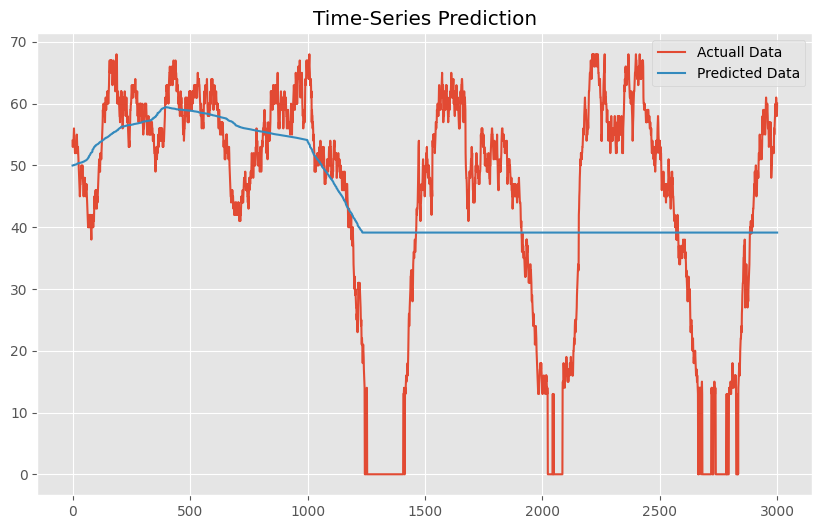

In [107]:
train_predict = lstm1(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 